In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from datetime import datetime, time
import glob
from autogluon.tabular import TabularDataset, TabularPredictor
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
def display_errors(y_true, y_pred, return_vals=False):
    mse = mean_squared_error(y_true, y_pred)
    print(f"MSE: {round(mse, 3)}")
    rmse = mse ** 0.5
    print(f"RMSE: {round(rmse, 3)}")
    mae = mean_absolute_error(y_true, y_pred)
    print(f"MAE: {round(mae, 3)}")
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"MAPE: {round(mape, 3)}")
    r2 = r2_score(y_true, y_pred)
    print(f"R2: {round(r2, 3)}")

    if return_vals:
        return [mse, rmse, mae, mape, r2]

def plot_errors(y_true, y_pred, name='N/A'):
    plt.scatter(y_true, y_pred, color='blue', marker='o', label=f'error adjusted predictions ({name}) vs actual degree days')
    plt.xlabel('actual degree days')
    plt.ylabel('predicted degree days')
    plt.title(f'Prediction vs Actual ({name})')

    max_value = max(max(y_true[-225:]), max(y_true[-225:]))
    min_value = min(min(y_true[-225:]), min(y_true[-225:]))
    plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Line of Equality')

    plt.legend()

In [3]:
class LinReg:
    def __init__(self, train_data, test_data, target_col):
        self.X_train = train_data.drop(columns=[target_col])
        self.y_train = train_data[target_col]
        self.X_test = test_data.drop(columns=[target_col])
        self.y_test = test_data[target_col]
        self.target_col = target_col
        self.model = LinearRegression().fit(self.X_train, self.y_train)
        self.y_pred = self.model.predict(self.X_test)
        self.evaluate()

    def evaluate(self):
        display_errors(self.y_test, self.y_pred)


In [4]:
def extract_date_time(filename):
    """
    extract the date and time from the filename
    :param filename:
    :return:
    """
    parts = filename.split('.')
    extracted_date = parts[1]
    extracted_time = parts[2]
    return extracted_date, extracted_time

def get_date(file):
        """get the date from the dataframe and the time from the filename and combine them into a datetime object
        :param file: filename containing the time
        :return: datetime object
        """

        date_str = str(file.split('.')[1])
        time_str = str(file.split('.')[2])
        date_value = datetime.strptime(date_str, '%Y%m%d')
        time_value = time(int(time_str), 0)
        combined_datetime = datetime.combine(date_value.date(), time_value)
        return combined_datetime
#give type hint on start_date that it should be a string
def seasonal_train_test(data, start_date: str, end_date: str):
    """
    split the data into train and test sets based on dates
    :param data: dataframe containing the data
    :param start_date: start date of the test set
    :param end_date: end date of the test set
    :return: train and test sets
    """

    test_start = start_date
    test_end = end_date
    test_data = data.loc[test_start: test_end]

    #remove X_test from dataframe to get X_train
    mask = (data.index >= test_start) & (data.index <= test_end)
    train_data = data.loc[~mask]

    return train_data, test_data

In [5]:
class RawDataProcess:
    def __init__(self, degree_days='gw_hdd', path='RawData', time=None):
        self.degree_days = degree_days
        self.path = path
        self.sort_files()
        self.get_master_model()
        if time is not None:
            self.filter_time(time)


    def filter_time(self, time):
        data = self.master_data
        data['hour'] = data.index.hour
        data = data[data['hour'] == time]
        data.drop('hour', axis=1, inplace=True)
        self.master_data = data

    def sort_files(self):
        """
        sort the files in the directory by date and time
        :return:
        """
        degree_days = self.degree_days
        path = self.path

        degree_days = degree_days
        ecmwf_files = glob.glob(path + f'/ecmwf.*.[01][02].{degree_days}.csv')
        ecmwf_sorted_files = sorted(ecmwf_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[3:]

        ecmwf_ens_files = glob.glob(path + f'/ecmwf-eps.*.[01][02].{degree_days}.csv')
        ecmwf_ens_sorted_files = sorted(ecmwf_ens_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

        gfs_ens_bc_files = glob.glob(path + f'/gfs-ens-bc.*.[01][02].{degree_days}.csv')
        gfs_ens_bc_sorted_files = sorted(gfs_ens_bc_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

        cmc_ens_files = glob.glob(path + f'/cmc-ens.*.[01][02].{degree_days}.csv')
        cmc_ens_sorted_files = sorted(cmc_ens_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]
        for _ in range(2):
            set1 = set((extract_date_time(filename) for filename in ecmwf_sorted_files))
            set2 = set((extract_date_time(filename) for filename in ecmwf_ens_sorted_files))

            ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in set2]
            ecmwf_ens_sorted_files = [filename for filename in ecmwf_ens_sorted_files if
                                      extract_date_time(filename) in set1]
            cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if extract_date_time(filename) in set1]

            master_set = set((extract_date_time(filename) for filename in cmc_ens_sorted_files))
            gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if
                                       extract_date_time(filename) in master_set]

            master_set = set((extract_date_time(filename) for filename in gfs_ens_bc_sorted_files))

            ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in master_set]
            ecmwf_ens_sorted_files = [filename for filename in ecmwf_ens_sorted_files if
                                      extract_date_time(filename) in master_set]
            gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if
                                       extract_date_time(filename) in master_set]
            cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if
                                    extract_date_time(filename) in master_set]

        self.ecmwf_sorted_files = ecmwf_sorted_files
        self.ecmwf_ens_sorted_files = ecmwf_ens_sorted_files
        self.gfs_ens_bc_sorted_files = gfs_ens_bc_sorted_files
        self.cmc_ens_sorted_files = cmc_ens_sorted_files

    def y_value(self, start=8, end=14):
        ecmwf_ens_9_14 = pd.DataFrame(columns=[f'ens({start+1},{end})'])

        ecmwf_ens_sorted_files = self.ecmwf_ens_sorted_files

        for i in range(1, len(ecmwf_ens_sorted_files)):
            ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i])
            ecmwf_ens_df = ecmwf_ens_df[ecmwf_ens_df[ecmwf_ens_df.columns[2]] >= 1]
            prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i - 1])
            prev_ecmwf_ens_df = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

            date = get_date(ecmwf_ens_sorted_files[i])
            prev_date = get_date(ecmwf_ens_sorted_files[i - 1])
            d2 = str(date)[:10]
            d1 = str(prev_date)[:10]

            if d2 == d1:
                offset = 1
            else:
                offset = 0

            cur = ecmwf_ens_df['Value'].iloc[start:end].sum()
            prev = prev_ecmwf_ens_df['Value'].iloc[(start+offset):(end+offset)].sum()
            change = cur - prev

            new_row = pd.DataFrame(change, columns=ecmwf_ens_9_14.columns, index=[date])
            ecmwf_ens_9_14 = pd.concat([ecmwf_ens_9_14, new_row])

        self.y_values = ecmwf_ens_9_14

    def ecmwf_ens(self, start=7, end=8):
        ecmwf_ens_8 = pd.DataFrame(columns=[f'ens({end})'])
        ecmwf_ens_sorted_files = self.ecmwf_ens_sorted_files

        for i in range(1, len(ecmwf_ens_sorted_files)):
            ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i])
            ecmwf_ens_df = ecmwf_ens_df[ecmwf_ens_df[ecmwf_ens_df.columns[2]] >= 1]
            prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i - 1])
            prev_ecmwf_ens_df = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

            date = get_date(ecmwf_ens_sorted_files[i])
            prev_date = get_date(ecmwf_ens_sorted_files[i - 1])
            d2 = str(date)[:10]
            d1 = str(prev_date)[:10]

            if d2 == d1:
                offset = 1
            else:
                offset = 0

            cur = ecmwf_ens_df['Value'].iloc[start:end].sum() #7-8 benchmark, 7-8 best results
            prev = prev_ecmwf_ens_df['Value'].iloc[(start+offset):(end+offset)].sum() #7-8 benchmark, 7-8 best results
            change = cur - prev

            new_row = pd.DataFrame(change, columns=ecmwf_ens_8.columns, index=[date])
            ecmwf_ens_8 = pd.concat([ecmwf_ens_8, new_row])

        self.ecmwf_ens_data = ecmwf_ens_8

    def ecmwf(self, start=8, end=9):

        ecmwf_9_10 = pd.DataFrame(columns=[f'ecmwf({end})'])

        ecmwf_sorted_files = self.ecmwf_sorted_files
        ecmwf_ens_sorted_files = self.ecmwf_ens_sorted_files


        for i in range(1, len(ecmwf_sorted_files)):
            ecmwf_df = pd.read_csv(ecmwf_sorted_files[i])
            ecmwf_df = ecmwf_df[ecmwf_df[ecmwf_df.columns[2]] >= 1]
            prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i-1])
            prev_ecmwf_ens_df = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

            date = get_date(ecmwf_sorted_files[i])
            prev_date = get_date(ecmwf_sorted_files[i - 1])
            d2 = str(date)[:10]
            d1 = str(prev_date)[:10]

            if d2 == d1:
                offset = 1
            else:
                offset = 0

            cur = ecmwf_df['Value'].iloc[start:end].sum() #8-9 benchmark, 4-9 best results
            prev = prev_ecmwf_ens_df['Value'].iloc[(start+offset):(end+offset)].sum() #8-9 benchmark, 4-9 best results

            change = cur - prev

            new_row = pd.DataFrame(change, columns=ecmwf_9_10.columns, index=[date])
            ecmwf_9_10 = pd.concat([ecmwf_9_10, new_row])

        self.ecmwf_data = ecmwf_9_10

    def gfs(self, start=9, end=14):
        gfs_11_14 = pd.DataFrame(columns=[f'gfs({start+1},{end})'])

        ecmwf_ens_sorted_files = self.ecmwf_ens_sorted_files
        gfs_ens_bc_sorted_files = self.gfs_ens_bc_sorted_files

        for i in range(1, len(gfs_ens_bc_sorted_files)):
            gfs_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
            gfs_df = gfs_df[gfs_df[gfs_df.columns[2]] >= 1]
            prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i-1])
            prev_ecmwf_ens_df = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

            date = get_date(gfs_ens_bc_sorted_files[i])
            prev_date = get_date(ecmwf_ens_sorted_files[i - 1])
            d2 = str(date)[:10]
            d1 = str(prev_date)[:10]

            if d2 == d1:
                offset = 1
            else:
                offset = 0

            cur = gfs_df['Value'].iloc[start:end].sum() # 9-14 benchmark, 9-16 best results
            prev = prev_ecmwf_ens_df['Value'].iloc[(start+offset):(end+offset)].sum() # 9-14 benchmark, 9-16 best results

            change = cur - prev

            new_row = pd.DataFrame(change, columns=gfs_11_14.columns, index=[date])
            gfs_11_14 = pd.concat([gfs_11_14, new_row])

        self.gfs_data = gfs_11_14

    def cmc(self, start=8, end=14):
        cmc_9_14 = pd.DataFrame(columns=[f'cmc({start+1},{end})'])

        cmc_ens_sorted_files = self.cmc_ens_sorted_files
        gfs_ens_bc_sorted_files = self.gfs_ens_bc_sorted_files

        for i in range(1, len(cmc_ens_sorted_files)):
            cmc_df = pd.read_csv(cmc_ens_sorted_files[i])
            cmc_df = cmc_df[cmc_df[cmc_df.columns[2]] >= 1]
            gfs_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
            gfs_df = gfs_df[gfs_df[gfs_df.columns[2]] >= 1]

            date = get_date(cmc_ens_sorted_files[i])

            cmc = cmc_df['Value'].iloc[start:end].sum() #8-14 benchmark, 8-14 best results
            gfs = gfs_df['Value'].iloc[start:end].sum() #8-14 benchmark, 8-14 best results
            change = cmc - gfs

            new_row = pd.DataFrame(change, columns=cmc_9_14.columns, index=[date])
            cmc_9_14 = pd.concat([cmc_9_14, new_row])

        self.cmc_data = cmc_9_14

    def norm(self):
        norms = pd.DataFrame(columns=['Date', 'Value'])
        ecmwf_ens_sorted_files = self.ecmwf_ens_sorted_files

        for i in range(1, len(ecmwf_ens_sorted_files), 2):
            ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i])
            v1 = ecmwf_ens_df[ecmwf_ens_df[ecmwf_ens_df.columns[2]] == 2].iloc[:, :2]
            norms = pd.concat([norms, v1]).drop_duplicates('Date')

        norms.reset_index(inplace=True)
        norms.drop(columns=['index'], inplace=True)
        norms['Date'] = pd.to_datetime(norms['Date']).dt.strftime('%Y-%m-%d 12:00:00')
        norms.set_index('Date', inplace=True)
        norms.rename_axis('', inplace=True)
        norms.rename(columns={'Value': 'norm'}, inplace=True)

        self.norms_data = norms

    def run_all_models(self):
        self.y_value()
        self.ecmwf_ens()
        self.ecmwf()
        self.gfs()
        self.cmc()
        self.norm()

    def get_master_model(self):
        self.run_all_models()
        master_data = pd.concat([self.ecmwf_ens_data, self.ecmwf_data,
                                 self.gfs_data, self.cmc_data, self.y_values], axis=1)

        self.master_data = master_data

In [6]:
data = RawDataProcess(degree_days='gw_hdd', path='RawData', time=12)

/var/folders/3y/4qthl0m139n7983g0dhsq1n00000gn/T/ipykernel_17816/2723095553.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('hour', axis=1, inplace=True)


In [9]:
master_data = data.master_data

In [52]:
train_data, test_data = seasonal_train_test(master_data, '2021-10-04 12:00:00', '2022-5-16 12:00:00')

In [53]:
train_data = TabularDataset(train_data)
test_data = TabularDataset(test_data)

In [54]:
label = 'ens(9,14)'

In [55]:
y_test = test_data[label]
test_data_nolabel = test_data.drop(columns=[label])

In [60]:
predictor = TabularPredictor(label=label).fit(train_data, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20230710_202309/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230710_202309/"
AutoGluon Version:  0.7.0
Python Version:     3.10.9
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 22.5.0: Thu Jun  8 22:22:19 PDT 2023; root:xnu-8796.121.3~7/RELEASE_ARM64_T8103
Train Data Rows:    1524
Train Data Columns: 46
Label Column: ens(9,14)
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (18.34899999999999, -21.283999999999992, 0.35771, 3.84261)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may

In [61]:
predictor.feature_importance(test_data, silent=True)

These features in provided data are not utilized by the predictor and will be ignored: ['snow_TMT7J', 'snow_KITR0', 'snow_KOTM0', 'tavg_72280', 'tmin_72280', 'tmax_72280', 'prcp_72280', 'pres_72280', 'snow_72280', 'snow_KNYL0']


,importance,stddev,p_value,n,p99_high,p99_low
ecmwf(9),0.400923,0.091882,0.000309,5,0.590109,0.211737
"gfs(10,14)",0.289470,0.037407,0.000033,5,0.366491,0.212448
ens(8),0.106100,0.090682,0.029516,5,0.292815,-0.080616
pres_KNYL0,0.034648,0.015423,0.003683,5,0.066404,0.002893
"cmc(9,14)",0.021462,0.023675,0.056293,5,0.070209,-0.027285
prcp_KOTM0,0.016158,0.015373,0.039249,5,0.047812,-0.015496
snow_71627,0.013997,0.016447,0.064892,5,0.047862,-0.019867
tmin_KITR0,0.013628,0.007653,0.008190,5,0.029386,-0.002131
pres_72529,0.007303,0.007320,0.044757,5,0.022374,-0.007768
pres_TMT7J,0.007277,0.011813,0.120205,5,0.031599,-0.017045


In [62]:
y_pred = predictor.predict(test_data_nolabel)
display_errors(y_test, y_pred)

MSE: 22.377
RMSE: 4.73
MAE: 3.701
MAPE: 1.669
R2: 0.201


In [58]:
linreg = LinReg(train_data, test_data, label)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# weather data

In [89]:
from meteostat import Stations, Daily

In [90]:
stations = Stations()
stations = stations.nearby(32.63, -114.62)

display(stations.fetch())

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
72280,Yuma / Yuma International,US,AZ,72280,KYUM,32.6500,-114.6000,65.0,America/Phoenix,1942-01-16,2007-01-05,1942-11-02,2006-12-25,1942-01-01,1995-01-01,2.907353e+03
KNYL0,Yuma / Desert Royal Mobile Park,US,AZ,<NA>,KNYL,32.6566,-114.6060,65.0,America/Phoenix,1988-01-01,2023-07-10,1988-01-01,2022-04-24,1988-01-01,2020-01-01,3.235241e+03
CDCYH,Yuma Auxiliary Airfield,US,AZ,<NA>,KNOZ,32.5000,-114.4500,105.0,America/Phoenix,2022-04-23,2023-07-05,2022-04-24,2022-04-26,NaT,NaT,2.151186e+04
KLGF0,Yuma / Laguna,US,AZ,<NA>,KLGF,32.8600,-114.3967,132.0,America/Phoenix,2020-01-14,2023-07-09,2020-01-15,2022-04-24,NaT,NaT,3.301838e+04
76005,Mexicali / Islas Agrarias Grupo B,MX,BCN,76005,MMML,32.6306,-115.2415,22.0,America/Tijuana,1990-03-14,2023-07-10,2020-03-10,2020-03-12,NaT,NaT,5.820016e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61984,Saint-Pierre,RE,<NA>,61984,FMEP,-21.3333,55.4833,52.0,Indian/Reunion,1973-01-02,2023-07-10,2013-03-10,2022-04-25,2015-01-01,2022-01-01,1.842337e+07
61995,Vacoas Mauritius,MU,PW,61995,<NA>,-20.3000,57.5000,423.0,Indian/Mauritius,NaT,NaT,1961-01-01,2023-07-02,1961-01-01,2021-01-01,1.843690e+07
61990,Plaisance Mauritius,MU,GP,61990,FIMP,-20.4333,57.6667,55.0,Indian/Mauritius,1949-02-01,2023-07-10,1951-01-01,2023-07-02,1951-01-01,2021-01-01,1.845814e+07


In [46]:

# stations
ids = ["72529", "TMT7J", "KITR0",
       "KOTM0", "71627", "72280", "KNYL0"]
# Set time period
start = datetime(2018, 7, 11)
end = datetime(2023, 5, 16)

# Get daily data
weather_df = pd.DataFrame()
for i in ids:
    data = Daily(i, start, end)
    data = data.fetch()
    data = data[['tavg', 'tmin', 'tmax', 'prcp', 'pres', 'snow']]
    data = data.add_suffix(f'_{i}')
    weather_df = pd.concat([weather_df, data], axis=1)

In [47]:
display(weather_df)

,tavg_72529,tmin_72529,tmax_72529,prcp_72529,pres_72529,snow_72529,tavg_TMT7J,tmin_TMT7J,tmax_TMT7J,prcp_TMT7J,...,tmax_72280,prcp_72280,pres_72280,snow_72280,tavg_KNYL0,tmin_KNYL0,tmax_KNYL0,prcp_KNYL0,pres_KNYL0,snow_KNYL0
time,,,,,,,,,,,,,,,,,,,,,
2018-07-11,23.8,15.6,26.7,0.0,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-12,21.8,12.8,30.6,0.0,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-13,25.1,17.8,32.2,0.0,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-14,26.6,21.7,33.9,0.0,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-15,25.7,20.0,32.8,0.0,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-12,19.6,11.1,27.8,0.0,1018.2,0.0,17.7,8.0,26.0,1.0,...,NaN,NaN,NaN,NaN,26.7,17.8,34.4,0.0,1008.8,NaN
2023-05-13,19.1,11.1,22.2,0.0,1020.8,0.0,16.8,10.6,23.3,0.0,...,NaN,NaN,NaN,NaN,28.5,19.4,38.0,0.0,1006.1,NaN
2023-05-14,13.0,6.7,15.6,0.0,1027.9,0.0,10.2,5.0,17.2,0.0,...,NaN,NaN,NaN,NaN,30.2,23.3,37.2,0.0,1009.4,NaN


In [48]:
weather_df.reset_index(inplace=True)
weather_df['Date'] = pd.to_datetime(weather_df['time']).dt.strftime('%Y-%m-%d 12:00:00')
weather_df.drop(columns=['time'], inplace=True)
weather_df.set_index('Date', inplace=True)
weather_df.rename_axis('', inplace=True)
weather_df.index = pd.to_datetime(weather_df.index)

In [51]:
common_dates = master_data.index.intersection(weather_df.index)
master_data = pd.concat([master_data.loc[common_dates], weather_df.loc[common_dates]], axis=1)

# ------------------

In [69]:
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3

Text(0.5, 1.0, 'Ineichen, climatological turbidity (Calgary)')

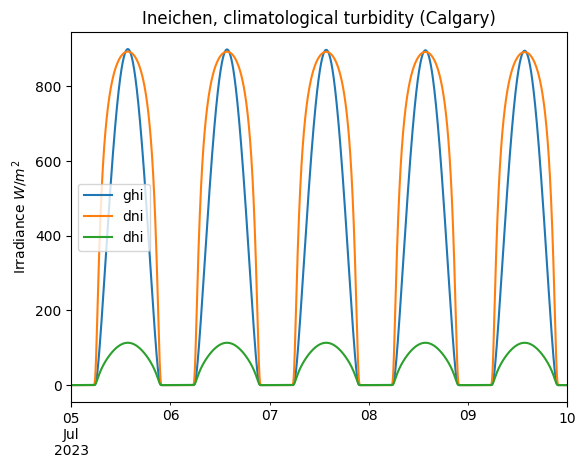

In [88]:
tus = Location(51.05, -114.09, 'Canada/Mountain', 700, 'Tucson')

times = pd.date_range(start='2023-07-5', end='2023-07-10', freq='1min', tz=tus.tz)

cs = tus.get_clearsky(times)  # ineichen with climatology table by default

cs.plot();
plt.ylabel('Irradiance $W/m^2$');
plt.title('Ineichen, climatological turbidity (Calgary)')

In [80]:
cs

,ghi,dni,dhi
2023-07-09 00:00:00-07:00,0.0,0.0,0.0
2023-07-09 00:01:00-07:00,0.0,0.0,0.0
2023-07-09 00:02:00-07:00,0.0,0.0,0.0
2023-07-09 00:03:00-07:00,0.0,0.0,0.0
2023-07-09 00:04:00-07:00,0.0,0.0,0.0
...,...,...,...
2023-07-12 23:56:00-07:00,0.0,0.0,0.0
2023-07-12 23:57:00-07:00,0.0,0.0,0.0
2023-07-12 23:58:00-07:00,0.0,0.0,0.0
2023-07-12 23:59:00-07:00,0.0,0.0,0.0


,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
KMRB0,Martinsburg / Grubbs Corner,US,WV,<NA>,KMRB,39.4019,-77.9847,172.0,America/New_York,1973-01-01,2023-07-10,1973-01-01,2022-04-24,2001-01-01,2022-01-01,3.355655e+06
